In [1]:
import pandas as pd
import datetime

df_checks = pd.read_csv("/Users/sirishaneduri/Downloads/Lenta hack/20210518_checks.csv")
df_offers = pd.read_csv("/Users/sirishaneduri/Downloads/Lenta hack/20210521_offers.csv")
df_gr = pd.read_csv("/Users/sirishaneduri/Downloads/Lenta hack/20210518_hierarchy.csv")

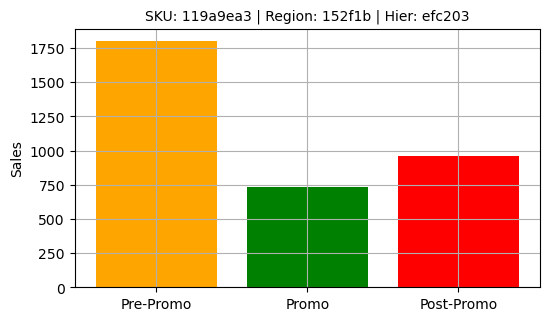

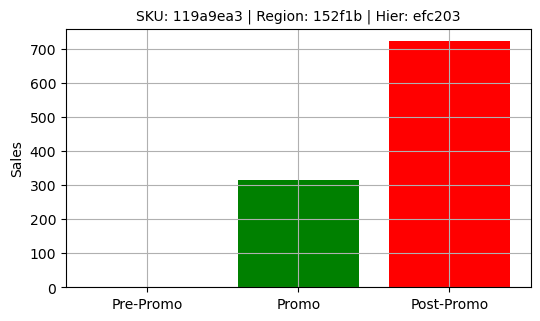

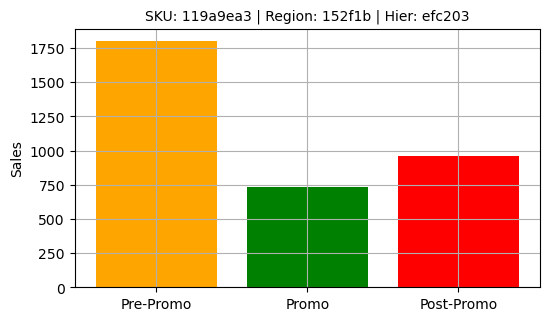

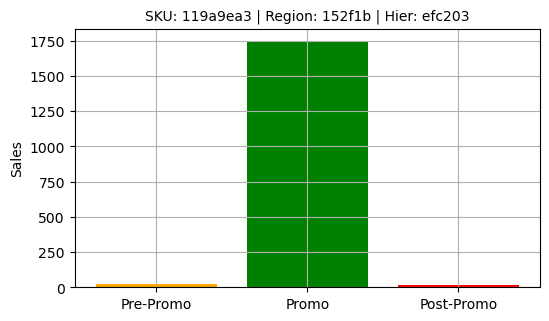

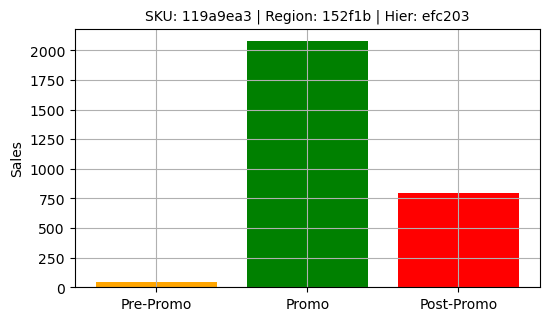

In [2]:
import tkinter as tk
from tkinter import ttk
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from datetime import timedelta

# --- Step 1: Preprocessing (fix dates first!) ---
df_checks['day'] = pd.to_datetime(df_checks['day'], format='%Y%m%d', errors='coerce')
merged_data = df_checks.merge(df_gr, on='sku', how='left')
REGULAR_PROMO_ID = "7215ee9c7d9dc229d2921a40e899ec5f"
promo_data = merged_data[merged_data['promo_id'] != REGULAR_PROMO_ID].copy()

# --- Step 2: GUI Setup ---
top_10_skus = [
    "119a9ea3a832472e1c163e5c1afba59e",
    "ef7bf412117548cb80b3f3b33a12977d",
    "0b689fd70e79d5010e397b4c453e8460",
    "7a8675a8f6988ebcbefd062fabaccc85",
    "8f4b2b5d481140b01c5b20bbf493b2b9",
    "911d7361089a37c2a6488a548b4f06a8",
    "fcbb8c2c4db0eb6a8aa153f30ac40e44",
    "a82bafb7c49b928c59143082375db8d8",
    "ca05b7e0598f23e3eebe4c0f4790e4e0",
    "f4d3eafd51353fcf6d574d457ad57a61",
    "787762f7d829ce318599bf015baba175",
    "92c77ef0ad96da2bcf81e5f8d854e40b",
    "bff9e04e1b854068f51e10b18482008e",
    "cd0757000bd4ee105534bbdb893c2062",
    "17f651ec385d3c235760cbe1d8e91f59",
    "33306ccd877e73c388652739869d3dc7",
    "2c04c192741b57a122ef8309515dc9fc"
]

root = tk.Tk()
root.title("Promo Efficiency Visual Tool")
root.configure(bg='#FFF2E5')
root.geometry("950x600")
root.columnconfigure(0, weight=1)
root.columnconfigure(1, weight=1)
root.rowconfigure(6, weight=1)

sku_var = tk.StringVar()
region_var = tk.StringVar()
hier_var = tk.StringVar()
promo_var = tk.StringVar()
output = tk.StringVar()

# --- Step 3: Update Dropdown Logic ---
def update_promos(event=None):
    sku = sku_var.get()
    if not sku:
        return

    subset = promo_data[promo_data['sku'] == sku]

    # Region options
    region_options = subset['region_name'].dropna().unique().tolist()
    region_combo['values'] = region_options
    if not region_var.get() or region_var.get() not in region_options:
        region_var.set(region_options[0])

    # Hierarchy options
    hier_options = subset['hierarchy_level4'].dropna().unique().tolist()
    hier_combo['values'] = hier_options
    if not hier_var.get() or hier_var.get() not in hier_options:
        hier_var.set(hier_options[0])

    # Promo ID options
    filtered = subset[
        (subset['region_name'] == region_var.get()) &
        (subset['hierarchy_level4'] == hier_var.get())
    ]
    promo_options = filtered['promo_id'].dropna().unique().tolist()
    promo_combo['values'] = promo_options
    if not promo_var.get() or promo_var.get() not in promo_options:
        if promo_options:
            promo_var.set(promo_options[0])
        else:
            promo_var.set('')
            output.set("No promo data available for this combination.")

# --- Step 4: Calculate Metrics & Show Plot ---
def calculate_metrics():
    sku = sku_var.get()
    region = region_var.get()
    hierarchy = hier_var.get()
    promo_id = promo_var.get()

    sku_subset = promo_data[
        (promo_data['sku'] == sku) &
        (promo_data['region_name'] == region) &
        (promo_data['hierarchy_level4'] == hierarchy)
    ]

    promo_period = sku_subset[sku_subset['promo_id'] == promo_id]
    promo_start = promo_period['day'].min()
    promo_end = promo_period['day'].max()

    if pd.isna(promo_start) or pd.isna(promo_end):
        output.set("Promo data not found or dates are missing.")
        return

    pre_start = promo_start - timedelta(days=14)
    pre_end = promo_start - timedelta(days=1)
    post_start = promo_end + timedelta(days=1)
    post_end = promo_end + timedelta(days=14)

    def calc_sales(start, end):
        return sku_subset[(sku_subset['day'] >= start) & (sku_subset['day'] <= end)]['num_sales'].sum()

    pre_sales = calc_sales(pre_start, pre_end)
    promo_sales = calc_sales(promo_start, promo_end)
    post_sales = calc_sales(post_start, post_end)
    uplift = ((promo_sales - pre_sales) / pre_sales * 100) if pre_sales > 0 else None

    avg_price_pre = sku_subset[(sku_subset['day'] >= pre_start) & (sku_subset['day'] <= pre_end)]['selling_price'].mean()
    avg_price_promo = sku_subset[(sku_subset['day'] >= promo_start) & (sku_subset['day'] <= promo_end)]['selling_price'].mean()
    price_effect = "Halo Effect (↑)" if avg_price_promo > avg_price_pre else "Cannibalization (↓)"

    result = f"Promo Period: {promo_start.date()} to {promo_end.date()}\n"
    result += f"Pre-Promo Sales: {pre_sales}\nPromo Sales: {promo_sales:.2f}\nPost-Promo Sales: {post_sales}\n"
    result += f"Promo Uplift: {uplift:.2f}%\n" if uplift is not None else "Promo Uplift: N/A\n"
    result += f"Avg Price Pre: £{avg_price_pre:.2f} | Promo: £{avg_price_promo:.2f} → {price_effect}"
    output.set(result)

    fig, ax = plt.subplots(figsize=(6, 3.5))
    ax.bar(['Pre-Promo', 'Promo', 'Post-Promo'], [pre_sales, promo_sales, post_sales], color=['orange', 'green', 'red'])
    ax.set_ylabel('Sales')
    ax.set_title(f"SKU: {sku[:8]} | Region: {region[:6]} | Hier: {hierarchy[:6]}", fontsize=10)
    ax.grid(True)

    for widget in plot_frame.winfo_children():
        widget.destroy()
    canvas = FigureCanvasTkAgg(fig, master=plot_frame)
    canvas.draw()
    canvas.get_tk_widget().pack()

# --- Step 5: GUI Widgets ---
ttk.Label(root, text="Select SKU:", background="#FFF2E5").grid(row=0, column=0, sticky='e')
sku_combo = ttk.Combobox(root, textvariable=sku_var, values=top_10_skus, state='readonly')
sku_combo.grid(row=0, column=1, sticky='w')
sku_combo.bind("<<ComboboxSelected>>", update_promos)

region_combo = ttk.Combobox(root, textvariable=region_var, state='readonly')
region_combo.grid(row=1, column=1, sticky='w')
region_combo.bind("<<ComboboxSelected>>", update_promos)
ttk.Label(root, text="Select Region:", background="#FFF2E5").grid(row=1, column=0, sticky='e')

hier_combo = ttk.Combobox(root, textvariable=hier_var, state='readonly')
hier_combo.grid(row=2, column=1, sticky='w')
hier_combo.bind("<<ComboboxSelected>>", update_promos)
ttk.Label(root, text="Select Hierarchy L4:", background="#FFF2E5").grid(row=2, column=0, sticky='e')

promo_combo = ttk.Combobox(root, textvariable=promo_var, state='readonly')
promo_combo.grid(row=3, column=1, sticky='w')
ttk.Label(root, text="Select Promo ID:", background="#FFF2E5").grid(row=3, column=0, sticky='e')

# Button + Output

btn = ttk.Button(root, text="Calculate Promo Efficiency", command=calculate_metrics)
btn.grid(row=4, column=0, columnspan=2, pady=10)

out_label = ttk.Label(root, textvariable=output, wraplength=600, justify='left', foreground='blue', background="#FFF2E5")
out_label.grid(row=5, column=0, columnspan=2, padx=10)

plot_frame = tk.Frame(root, bg="#FFF2E5")
plot_frame.grid(row=6, column=0, columnspan=2, pady=10, sticky='nsew')

root.mainloop()
